# Цель:
В этом домашнем задании вам предстоит настроить систему по поиску аномалий в банковских транзакциях. Мало того, что аномальных значений в данных меньше одного процента, так еще и переменные анонимизированные и представляют собой первые 28 главных компонент, полученных после PCA преобразования оригинальных данных (о которых мы ничего не знаем).

Смогут ли бравые unsupervised методы справиться с такой задачей? Можно ли работать в таких условиях? Кто подставил кролика Роджера? Ответы на некоторые их этих вопросов вы узнаете после выполнения задания :)


# Описание/Пошаговая инструкция выполнения домашнего задания:
- Скачайте датасет с https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv
- Проведите небольшой EDA (гистограммы и описательные статистики - обязательно).
- Воспользуйтесь процентом аномалий, подсчитанным по переменной Class, как "экспертной оценкой" загрязненности нашего датасета.
- Попробуйте построить различные модели и алгоритмы, разобранные на занятии, используя полученную экспертную оценку для настройки параметров.
- Воспользуйтесь стандартными методами оценки качества бинарной классификации (особенно хорошо подойдёт classification report и confusion matrix), и, используя предсказания моделей и переменную Class, проверьте, действительно ли модели справляются со своей задачей и насколько хорошо они это делают.
- При помощи tSNE и/или UMAP, постройте сжатое представление исходных данных и проверьте, действительно ли аномалии лежат достаточно далеко от основной массы точек.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import hdbscan
import umap



In [3]:
df = pd.read_csv('creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,2.238554e-15,1.724421e-15,-1.245415e-15,8.238900e-16,1.213481e-15,4.866699e-15,1.436219e-15,-3.768179e-16,9.707851e-16,1.036249e-15,6.418678e-16,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

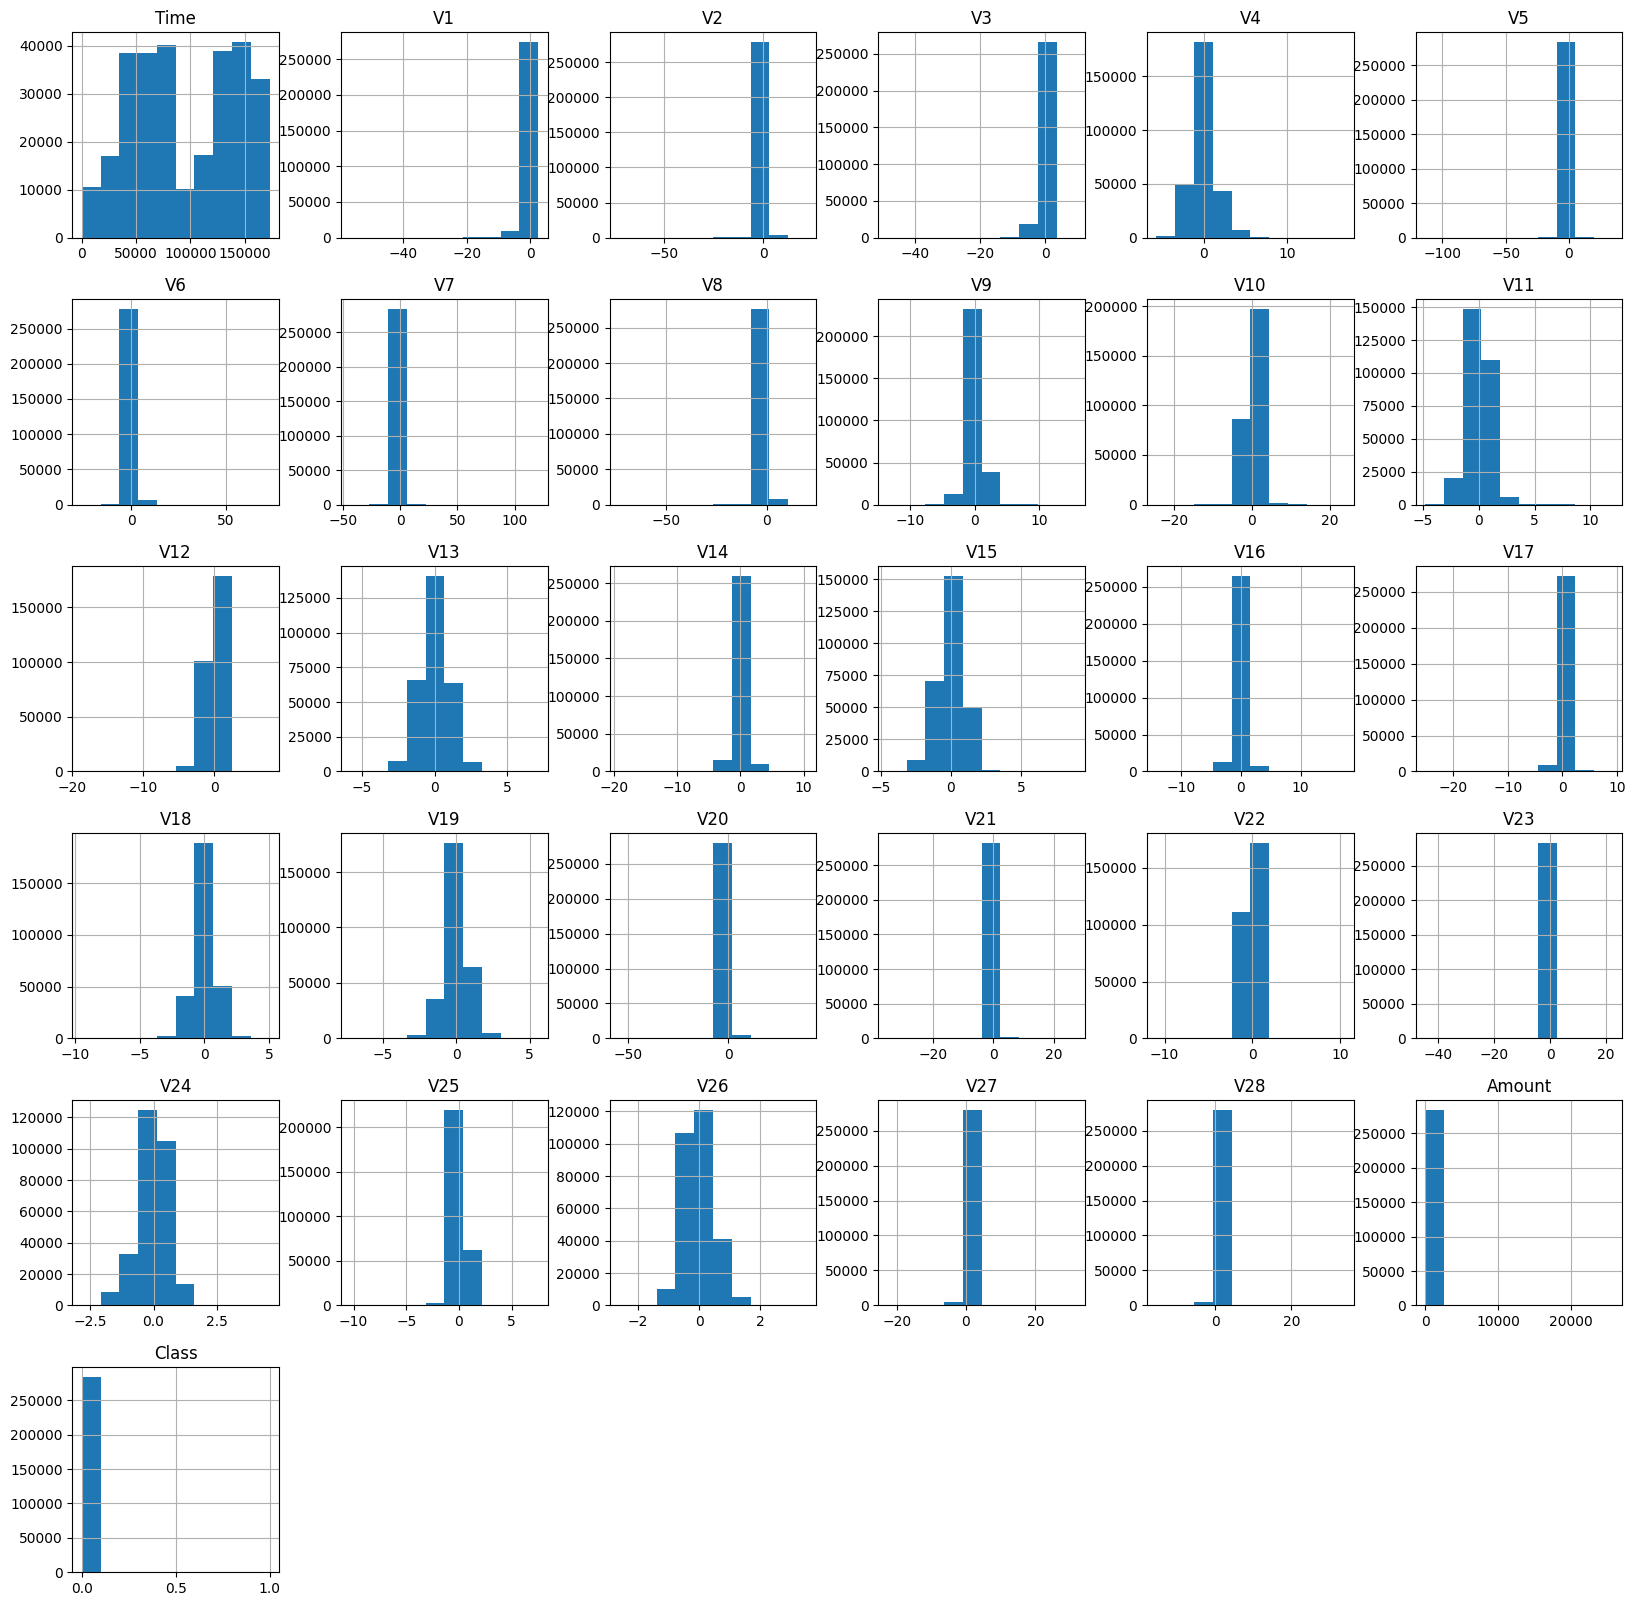

In [6]:
df.hist(figsize=(20, 20))

<Axes: >

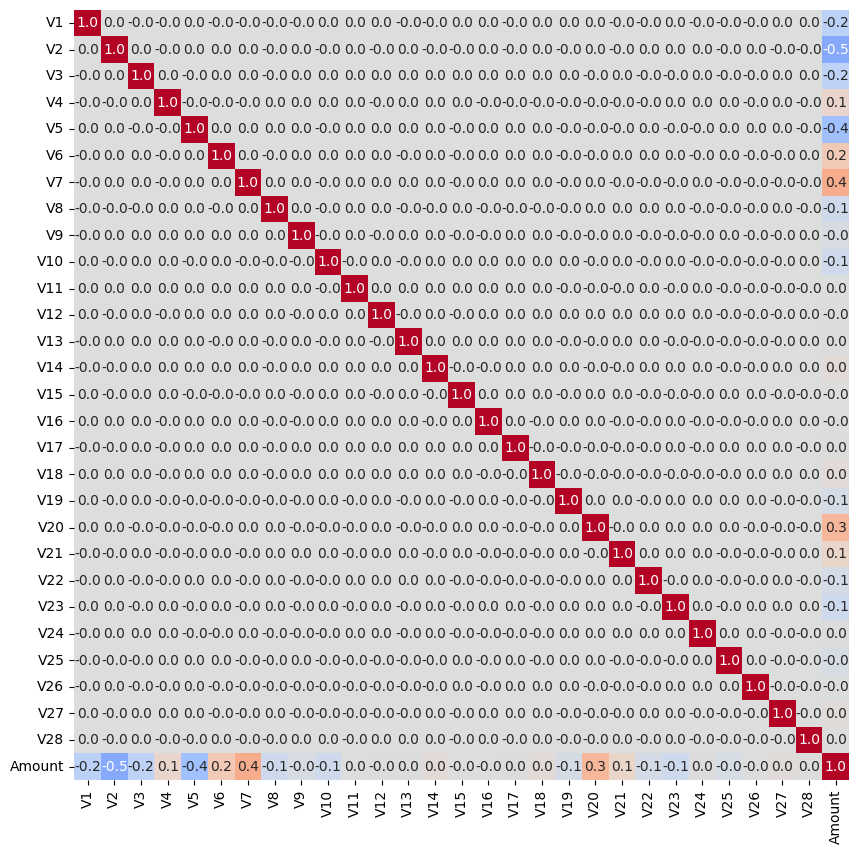

In [7]:
plt.figure(figsize=(10,10))
df_features = df.drop('Class', axis=1).drop('Time', axis=1)
sns.heatmap(df_features.corr(), annot=True, cmap="coolwarm",fmt='.1f', cbar=False, center=0)

In [8]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [9]:
df['Class'].value_counts(normalize=True) * 100

Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

Аномалий 0,17%

In [10]:
X_scaled = RobustScaler().fit_transform(df_features)

In [11]:

vis_model = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.0,
    metric="euclidean",
    random_state=42
)

X_vis = vis_model.fit_transform(X_scaled)

/Users/vadim/Code/OTUS/ML-Prof/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


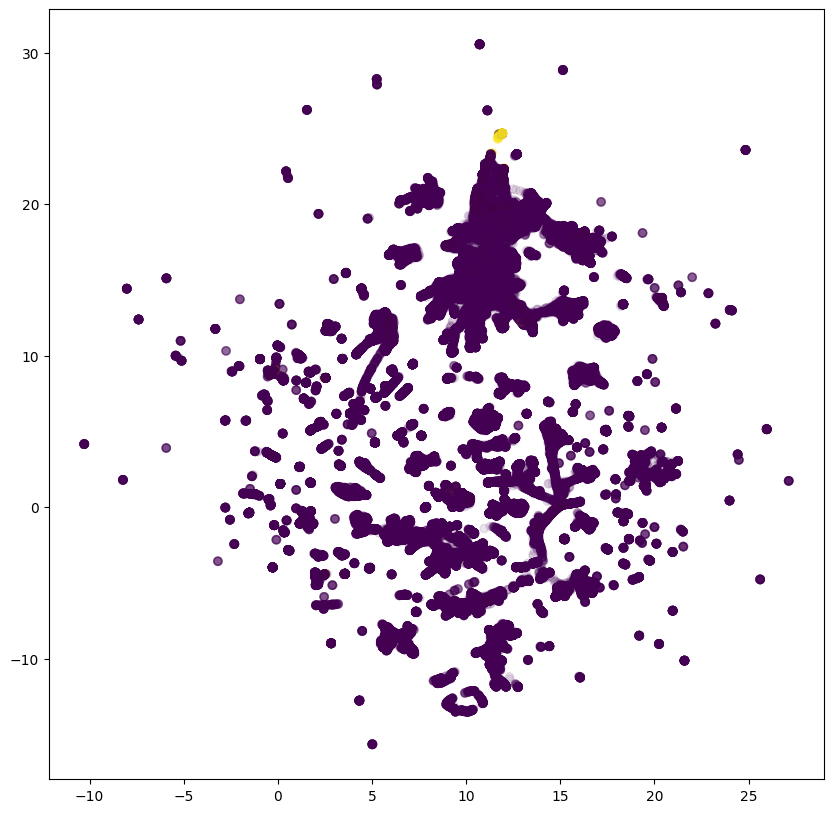

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=df['Class'], alpha=0.1)

# Межквартильный размах

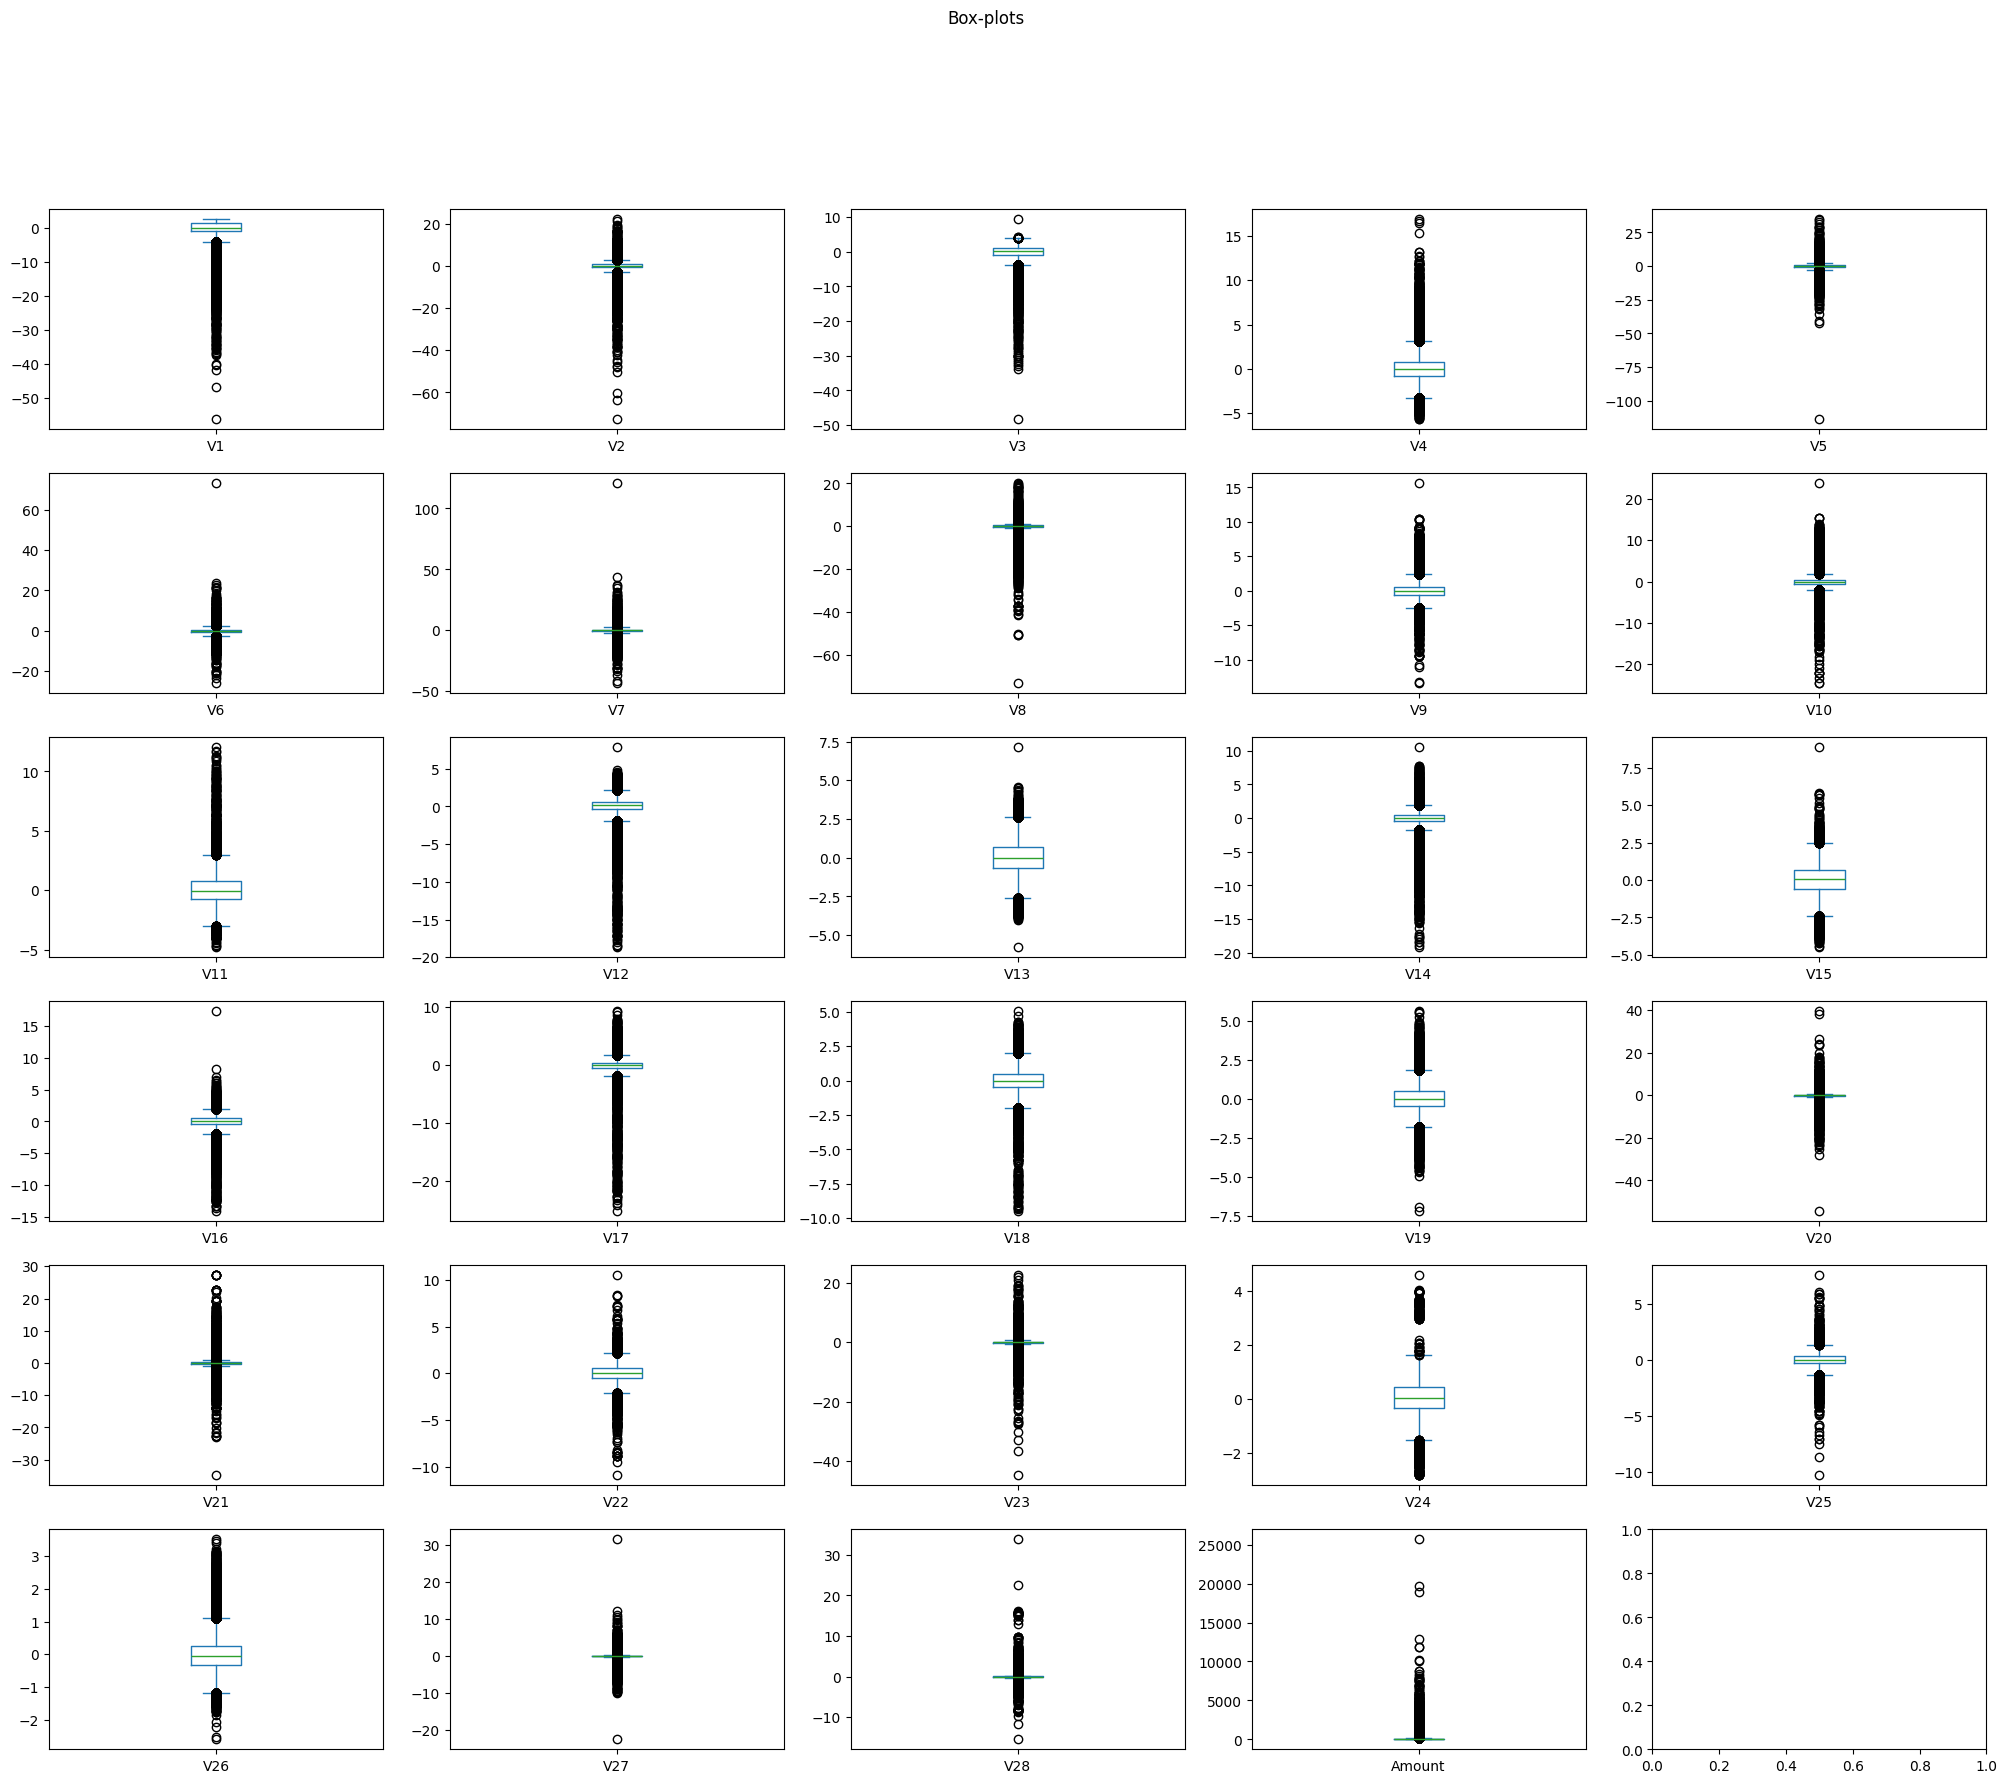

In [13]:
fig, axes = plt.subplots(6, 5, figsize=(25, 20))
fig.suptitle('Box-plots')

row=0
col=0

for ax, feature in enumerate(df_features.columns):
    df_features[feature].plot.box(ax=axes[row, col])
    col+=1
    if col > 4:
        row+=1
        col=0

In [14]:
def count_iqr_outliers_per_row(df, cols=None, k=1.5):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns

    # Квартиль 1 и 3 по выбранным столбцам
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - k * IQR
    upper = Q3 + k * IQR

    mask_outlier = (df[cols] < lower) | (df[cols] > upper)

    # Число выбросных признаков в строке

    return mask_outlier.sum(axis=1)


In [15]:
df['n_iqr_outliers'] = count_iqr_outliers_per_row(df_features)


In [16]:
df['n_iqr_outliers'].describe()

count    284807.000000
mean          1.300432
std           2.200271
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          28.000000
Name: n_iqr_outliers, dtype: float64

In [17]:
outliners = []
total = df.shape[0]
for i in range(0, 29):
    count = df[df['n_iqr_outliers'] >= i].shape[0]
    outliners.append(count/total)

for i, percent in enumerate(outliners): print(f'{i}: {percent*100}') 

0: 100.0
1: 48.61994262781463
2: 28.591291646623855
3: 16.543132717945838
4: 10.699877460877016
5: 7.193643414663263
6: 5.046224285217709
7: 3.6789826092757547
8: 2.700425200223309
9: 1.989066279972051
10: 1.4248245302959548
11: 1.020340089955654
12: 0.7380436576348194
13: 0.5287791381532055
14: 0.3461993560551531
15: 0.2563139248684197
16: 0.18117532223575963
17: 0.14044598622927107
18: 0.11376124884570957
19: 0.08883208629001395
20: 0.062498463872025616
21: 0.041782680903208136
22: 0.019662438072097947
23: 0.009831219036048973
24: 0.004915609518024487
25: 0.001755574827865888
26: 0.0007022299311463553
27: 0.00035111496557317765
28: 0.00035111496557317765


Наиболее близко к целевому показателю выбросов наличие выбросов по 16 или 17 признакам.

Учитывая, что это банковские транзакции и лучше чуть более жесткиий подход выбираем, что выбросом будет все, где есть выбросы по 16 и более признакам


In [18]:
def report(y_true, y_pred):
    plt.figure(figsize=(10, 10))
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_pred, alpha=0.1)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.34      0.36      0.35       492

    accuracy                           1.00    284807
   macro avg       0.67      0.68      0.68    284807
weighted avg       1.00      1.00      1.00    284807

[[283976    339]
 [   315    177]]


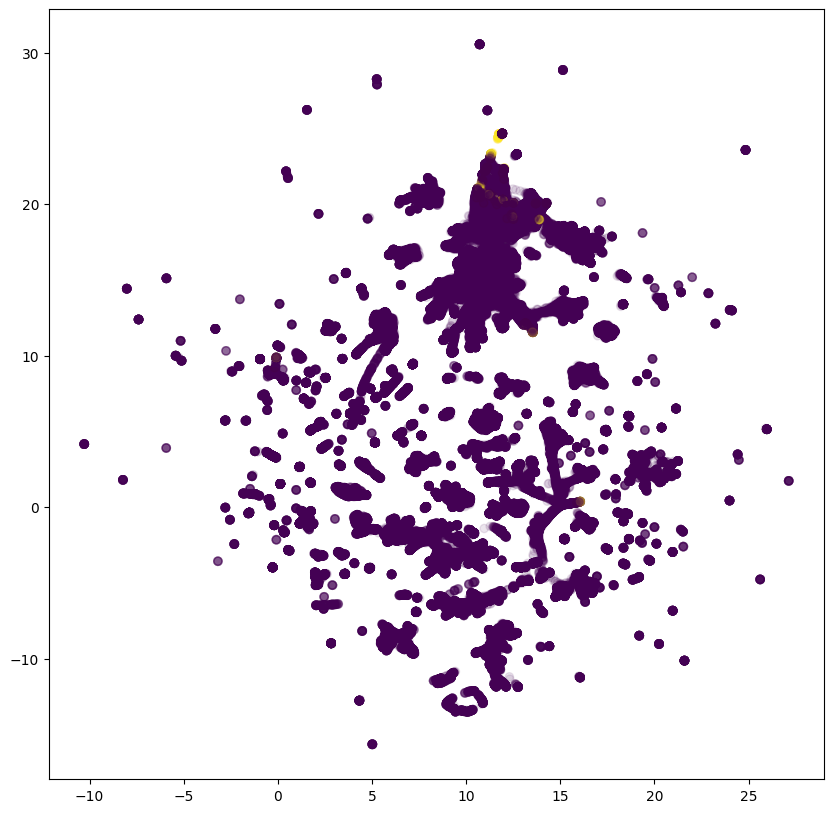

In [19]:
report(df['Class'], df['n_iqr_outliers']>=16 )

Пока выглядит так себе. Только треть поймали. Попробуем подобрать порог 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    284315
           1       0.08      0.68      0.15       492

    accuracy                           0.99    284807
   macro avg       0.54      0.83      0.57    284807
weighted avg       1.00      0.99      0.99    284807

[[280593   3722]
 [   156    336]]


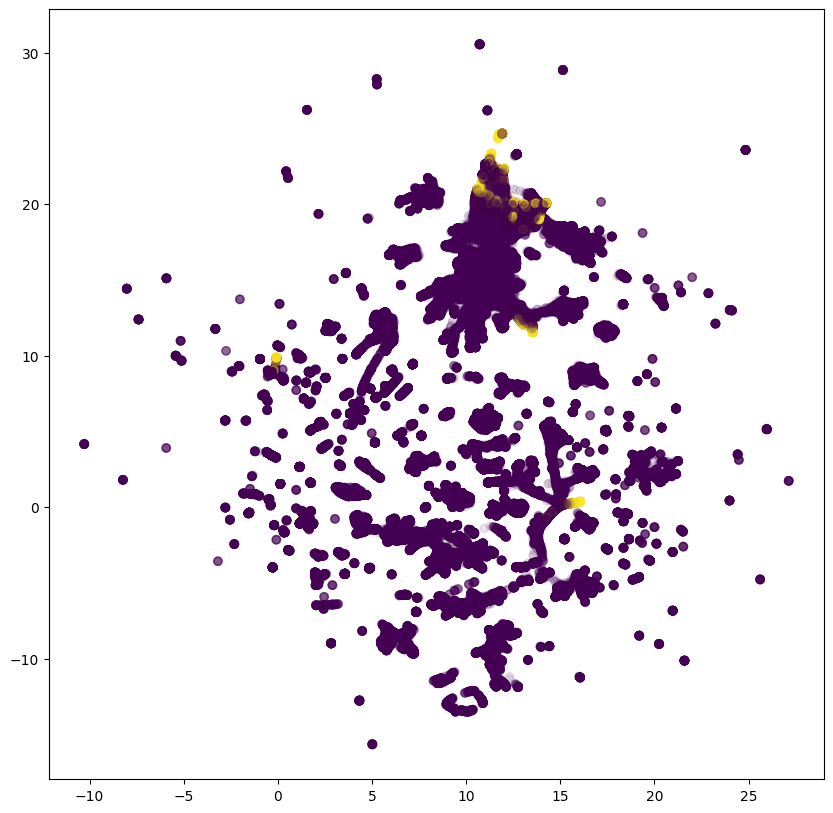

In [20]:
report(df['Class'], df['n_iqr_outliers']>=10)

Даже при границе в 10 признаков предсказание оставляет желать лучшего. Попробую уменьшить размерность до 25

In [21]:
X_pca = PCA(n_components=25).fit_transform(X_scaled)

In [22]:
df['n_iqr_pca'] = count_iqr_outliers_per_row(
    pd.DataFrame(X_pca)
)


In [23]:
df['n_iqr_pca'].describe()

count    284807.000000
mean          1.239369
std           2.083605
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          24.000000
Name: n_iqr_pca, dtype: float64

In [24]:
outliners = []
total = df.shape[0]
for i in range(0, 26):
    count = df[df['n_iqr_pca'] >= i].shape[0]
    outliners.append(count/total)

for i, percent in enumerate(outliners): print(f'{i}: {percent*100}') 

0: 100.0
1: 47.97950893060915
2: 26.71914665018767
3: 15.973975358751716
4: 10.400025280277521
5: 7.011063632565211
6: 4.811328373249253
7: 3.3577124157762976
8: 2.3391279006485095
9: 1.6498892232283617
10: 1.1874708135684868
11: 0.8398669976510408
12: 0.5775841183678773
13: 0.395355451235398
14: 0.25947395955857827
15: 0.16502403381939348
16: 0.11657016857029498
17: 0.07338302780479412
18: 0.04388937069664721
19: 0.021418012899963836
20: 0.009831219036048973
21: 0.004213379586878132
22: 0.00035111496557317765
23: 0.00035111496557317765
24: 0.00035111496557317765
25: 0.0


Попробуем начать с 14

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.23      0.35      0.28       492

    accuracy                           1.00    284807
   macro avg       0.62      0.67      0.64    284807
weighted avg       1.00      1.00      1.00    284807

[[283748    567]
 [   320    172]]


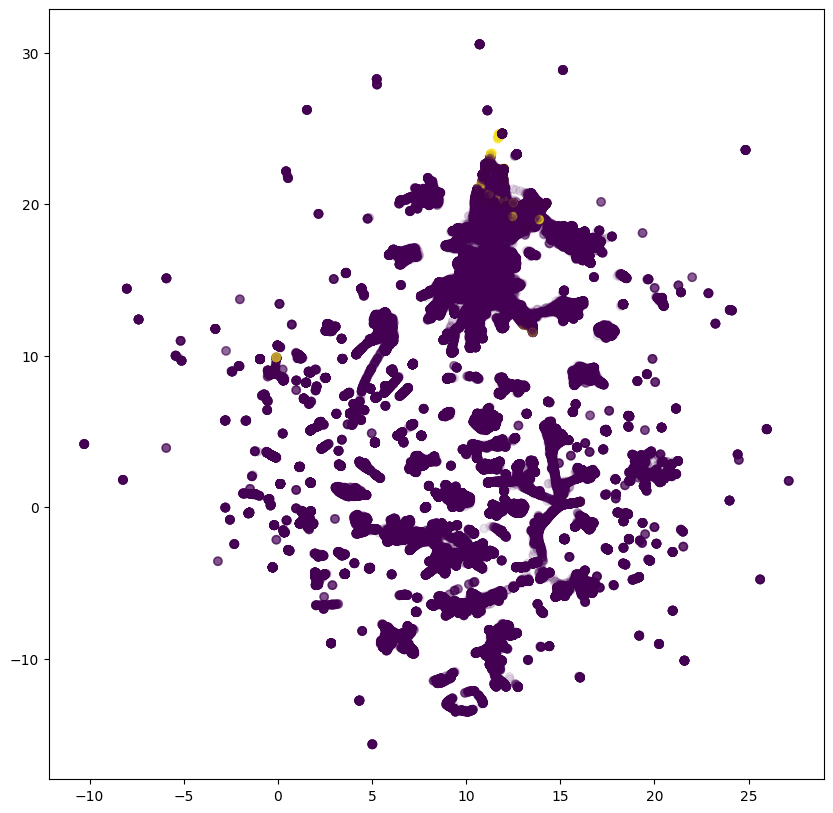

In [25]:
report(df['Class'], df['n_iqr_pca']>=14)

Результат тоже так себе. Попробуем поподбирать порог


              precision    recall  f1-score   support

           0       1.00      0.97      0.98    284315
           1       0.04      0.81      0.08       492

    accuracy                           0.97    284807
   macro avg       0.52      0.89      0.53    284807
weighted avg       1.00      0.97      0.98    284807

[[275149   9166]
 [    95    397]]


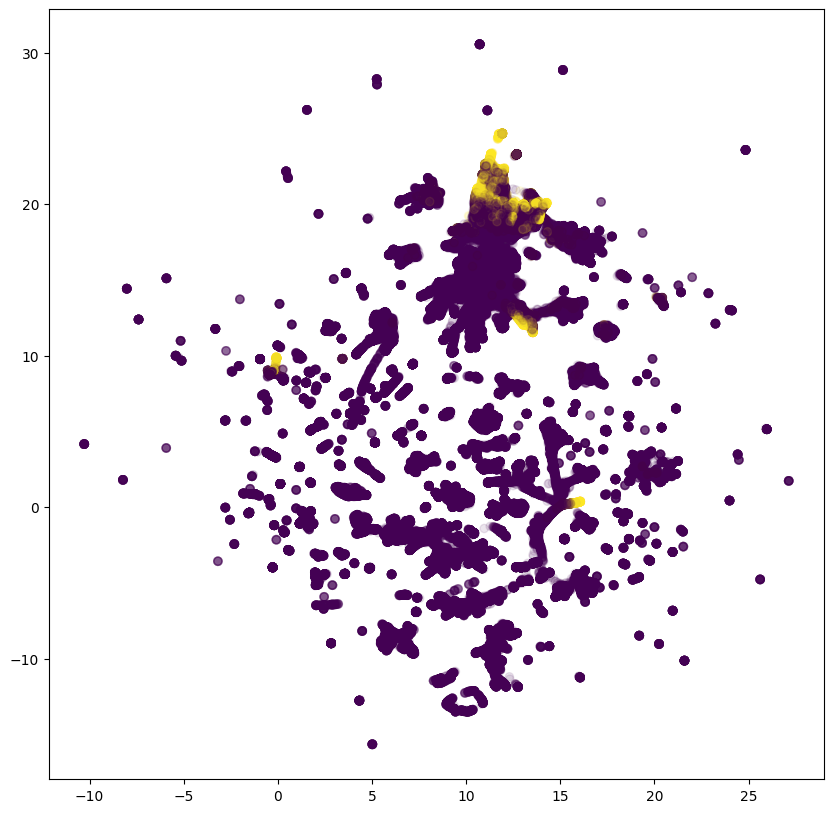

In [26]:
report(df['Class'], df['n_iqr_pca']>=7)

В несжатом пространстве выглядело лучше, на мой взгляд

In [42]:
df['iqr'] = (df['n_iqr_outliers']>=10).astype(int)

# DBSCAN

In [27]:
# Без уменьшения размерности DBSCAN сваливался в панику из-за большого эпсилона
umap_model = umap.UMAP(
    n_components=10,
    n_neighbors=30,
    min_dist=0.0,
    metric="euclidean",
    random_state=42
)

X_emb = umap_model.fit_transform(X_scaled)

/Users/vadim/Code/OTUS/ML-Prof/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [28]:
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# берем маленький эпсилон и начинаем увеличивать
eps = 0.21
eps_history = [eps]
while outlier_percentage>0.0017:
    model = DBSCAN(eps=eps).fit(X_emb)
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    # считаем текущий процент "шума"
    outlier_percentage = sum(labels==1) / len(labels)
    eps_history.append(eps)
    print(f'eps: {eps}, outlier_percentage: {outlier_percentage * 100}', num_clusters[-1])
    anomaly_percentage.append(outlier_percentage)
    eps += 0.001

eps: 0.21, outlier_percentage: 0.1959221507898331 172
eps: 0.211, outlier_percentage: 0.18925096644394274 170
eps: 0.212, outlier_percentage: 0.18573981678821097 170
eps: 0.213, outlier_percentage: 0.18117532223575963 170
eps: 0.214, outlier_percentage: 0.17520636782101562 169
eps: 0.215, outlier_percentage: 0.1713441031997107 168
eps: 0.216, outlier_percentage: 0.1678329535439789 163


Возьмем эпсилон = 0.214

In [29]:
model = DBSCAN(eps=0.214).fit(X_emb)

In [30]:
df['dbscan'] = (model.labels_ == -1).astype(int)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.00      0.00      0.00       492

    accuracy                           1.00    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      1.00      1.00    284807

[[283816    499]
 [   492      0]]


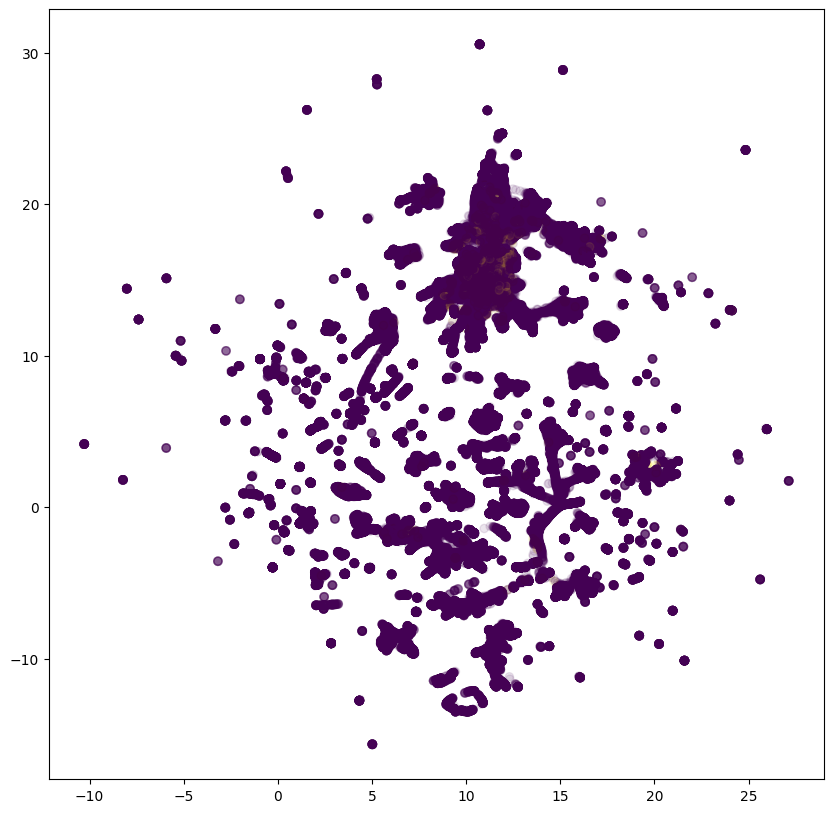

In [31]:
report(df['Class'], df['dbscan'])

Вообще ни одного попадания. Возьмем эпсилон на котором не падает = 4

In [32]:
model = DBSCAN(eps=4.).fit(X_scaled)
labels = model.labels_
labels = np.array([1 if label == -1 else 0 for label in labels])

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    284315
           1       0.03      0.67      0.06       492

    accuracy                           0.96    284807
   macro avg       0.51      0.82      0.52    284807
weighted avg       1.00      0.96      0.98    284807

[[273111  11204]
 [   160    332]]


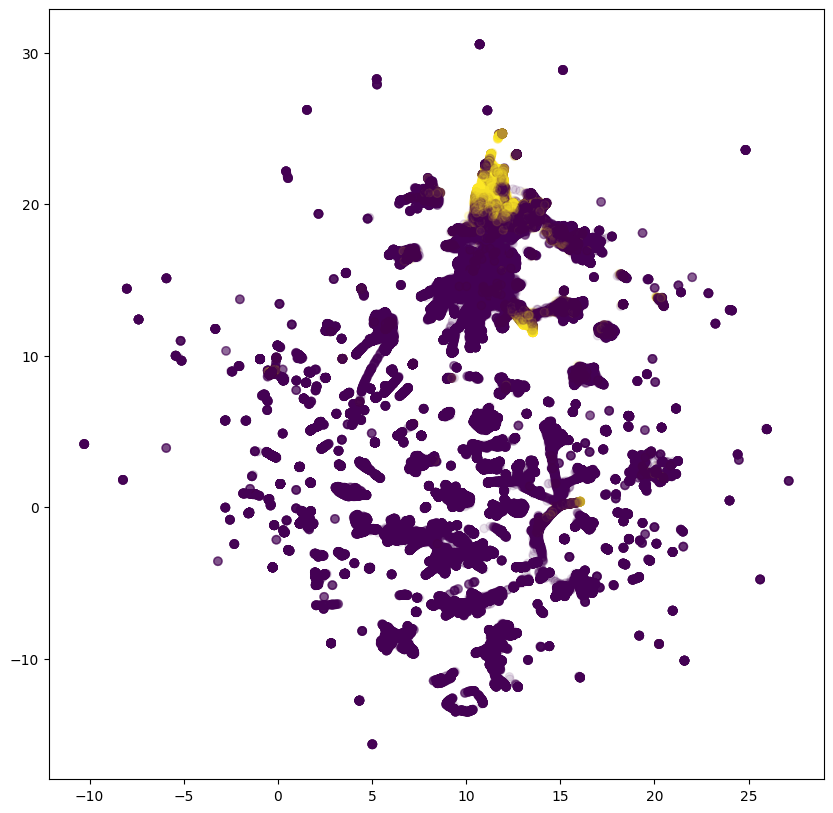

In [33]:
report(df['Class'], labels)

Выглядит лучше, но много ложных срабаотываний


In [43]:
df['dbscan'] = labels

# Isolation Forest


In [38]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01,
                                   max_features=1.0, bootstrap=True)
isolation_forest.fit(X_scaled)

isolation_outliers = isolation_forest.predict(X_scaled)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    284315
           1       0.06      0.72      0.11       492

    accuracy                           0.98    284807
   macro avg       0.53      0.85      0.55    284807
weighted avg       1.00      0.98      0.99    284807

[[278970   5345]
 [   140    352]]


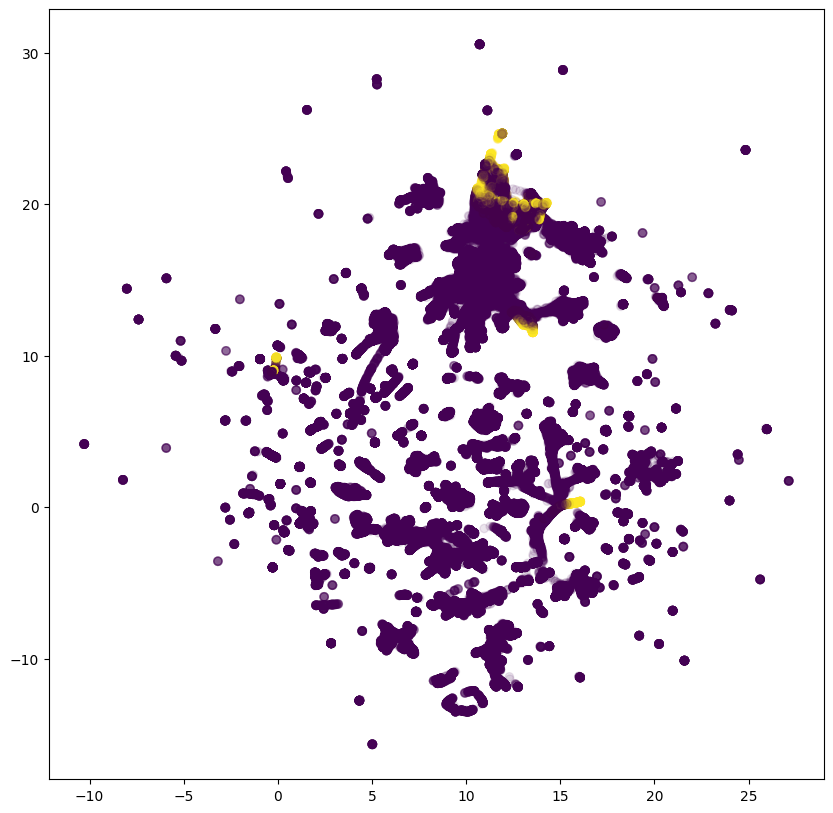

In [37]:
report(df['Class'], isolation_outliers)

По сравнению с другими выглядит не плохо

In [44]:
df['isolation'] = isolation_outliers

# OneClassSVM

In [39]:
one_class_svm = OneClassSVM(nu=0.01, gamma='auto')
one_class_svm.fit(X_scaled)
svm_outliers = one_class_svm.predict(X_scaled)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    284315
           1       0.06      0.40      0.10       492

    accuracy                           0.99    284807
   macro avg       0.53      0.70      0.55    284807
weighted avg       1.00      0.99      0.99    284807

[[281086   3229]
 [   294    198]]


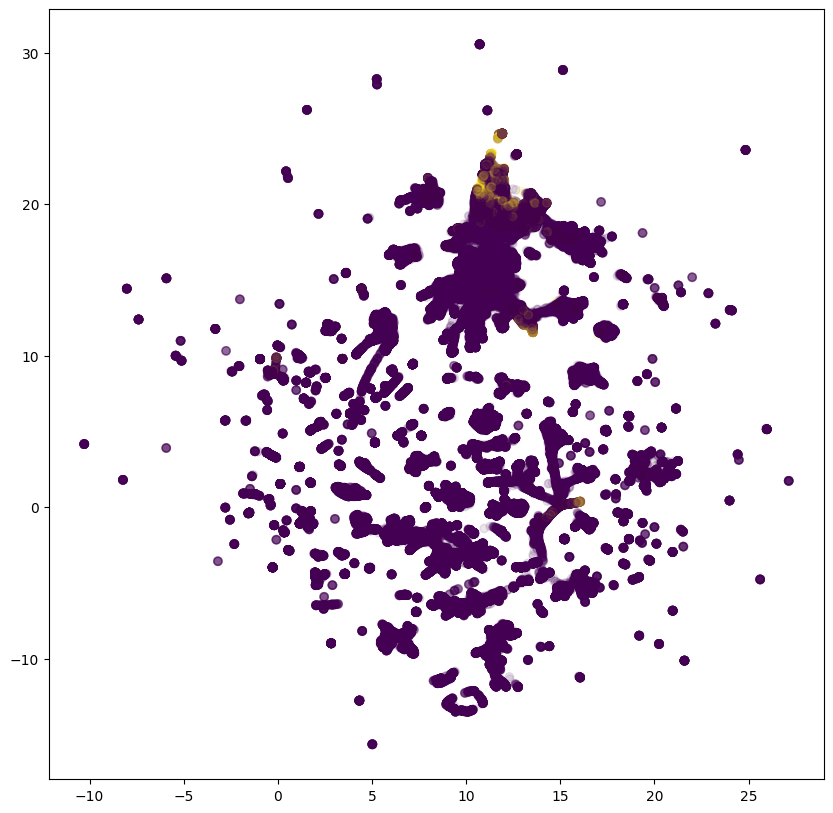

In [40]:
report(df['Class'], svm_outliers)

Так себе результат


In [45]:
df['svm'] = svm_outliers

In [48]:
df[df['Class']==1].head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,n_iqr_outliers,n_iqr_pca,dbscan,iqr,isolation,svm
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1,9,6,1,0,0,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1,4,4,0,0,0,0
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1,5,6,1,0,0,0
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1,11,9,1,1,0,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1,14,12,1,1,0,0
6331,7526.0,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,-6.187891,5.664395,-9.854485,-0.306167,-10.691196,-0.638498,-2.041974,-1.129056,0.116453,-1.934666,0.488378,0.364514,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1.00,1,14,12,1,1,1,0
6334,7535.0,0.026779,4.132464,-6.560600,6.348557,1.329666,-2.513479,-1.689102,0.303253,-3.139409,-6.045468,6.754625,-8.948179,0.702725,-10.733854,-1.379520,-1.638960,-1.746350,0.776744,-1.327357,0.587743,0.370509,-0.576752,-0.669605,-0.759908,1.605056,0.540675,0.737040,0.496699,1.00,1,12,11,1,1,1,0
6336,7543.0,0.329594,3.712889,-5.775935,6.078266,1.667359,-2.420168,-0.812891,0.133080,-2.214311,-5.134454,4.560720,-8.873748,-0.797484,-9.177166,-0.257025,-0.871688,1.313014,0.773914,-2.370599,0.269773,0.156617,-0.652450,-0.551572,-0.716522,1.415717,0.555265,0.530507,0.404474,1.00,1,11,10,1,1,0,1
6338,7551.0,0.316459,3.809076,-5.615159,6.047445,1.554026,-2.651353,-0.746579,0.055586,-2.678679,-4.959493,6.439053,-7.520117,0.386352,-9.252307,-1.365188,-0.502362,0.784427,1.494305,-1.808012,0.388307,0.208828,-0.511747,-0.583813,-0.219845,1.474753,0.491192,0.518868,0.402528,1.00,1,12,11,0,1,0,0
6427,7610.0,0.725646,2.300894,-5.329976,4.007683,-1.730411,-1.732193,-3.968593,1.063728,-0.486097,-4.624985,5.588724,-7.148243,1.680451,-6.210258,0.495282,-3.599540,-4.830324,-0.649090,2.250123,0.504646,0.589669,0.109541,0.601045,-0.364700,-1.843078,0.351909,0.594550,0.099372,1.00,1,12,13,1,1,1,0


# Итог

Попробуем совместить несколько выбросов вместе

In [49]:
df['w_outliers'] = df['iqr'] + df['dbscan'] + df['isolation'] + df['svm']

1
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    284315
           1       0.03      0.81      0.06       492

    accuracy                           0.95    284807
   macro avg       0.52      0.88      0.52    284807
weighted avg       1.00      0.95      0.98    284807

[[271574  12741]
 [    93    399]]
2
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    284315
           1       0.03      0.81      0.06       492

    accuracy                           0.95    284807
   macro avg       0.52      0.88      0.52    284807
weighted avg       1.00      0.95      0.98    284807

[[271574  12741]
 [    93    399]]
3
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    284315
           1       0.03      0.81      0.06       492

    accuracy                           0.95    284807
   macro avg       0.52      0.88      0.52    28480

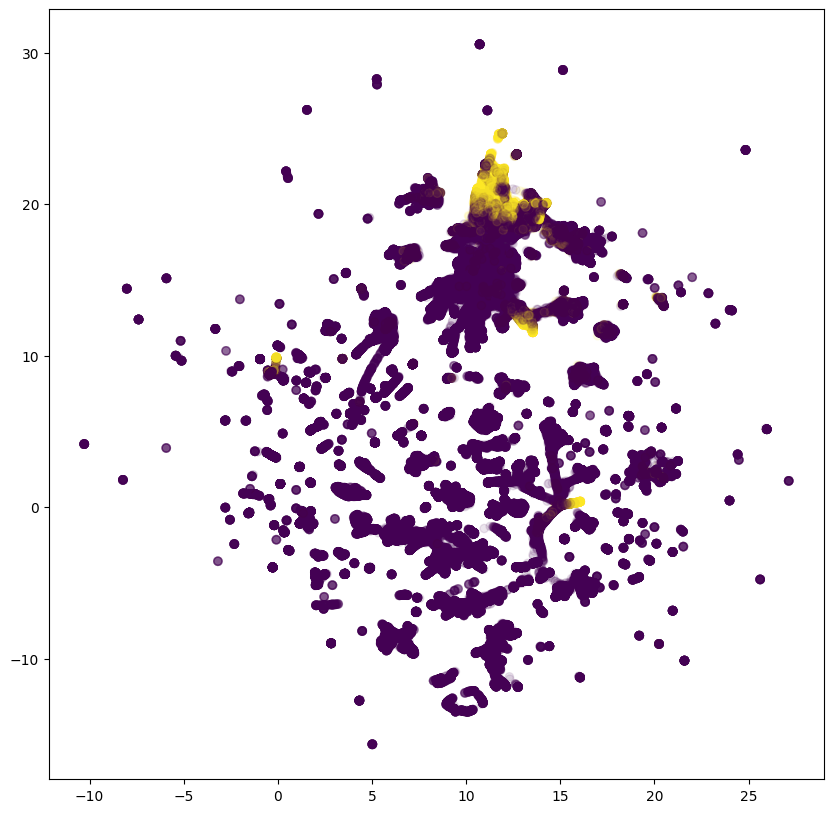

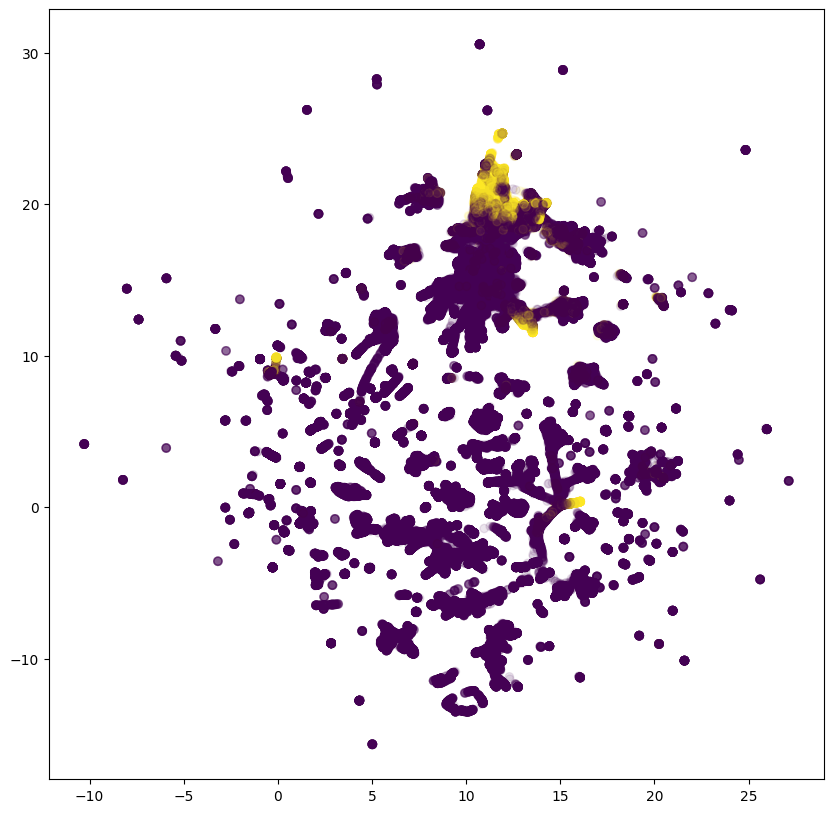

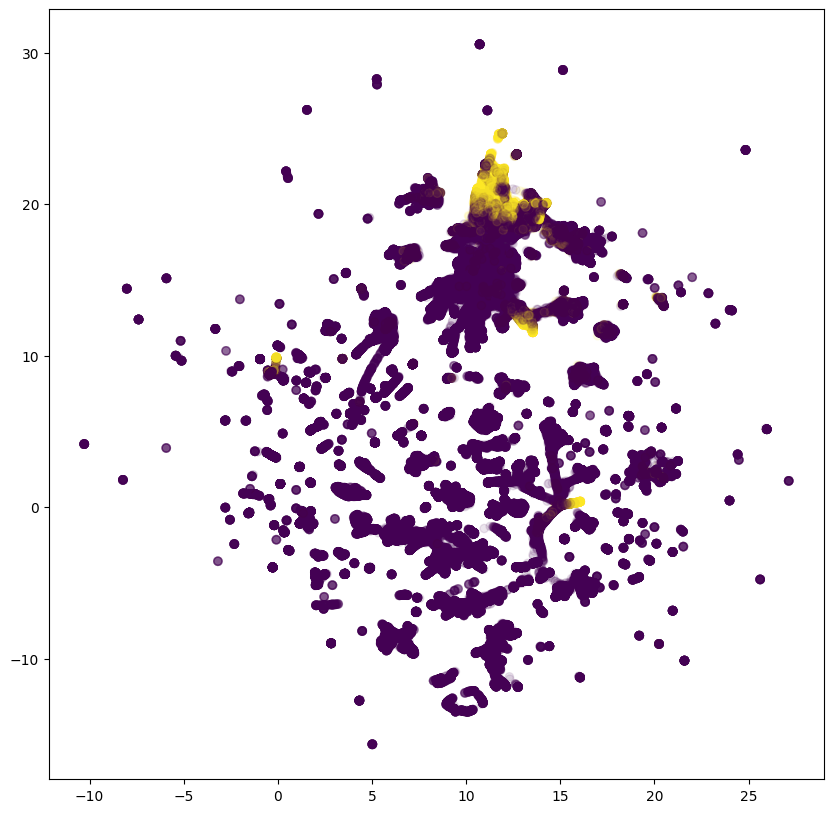

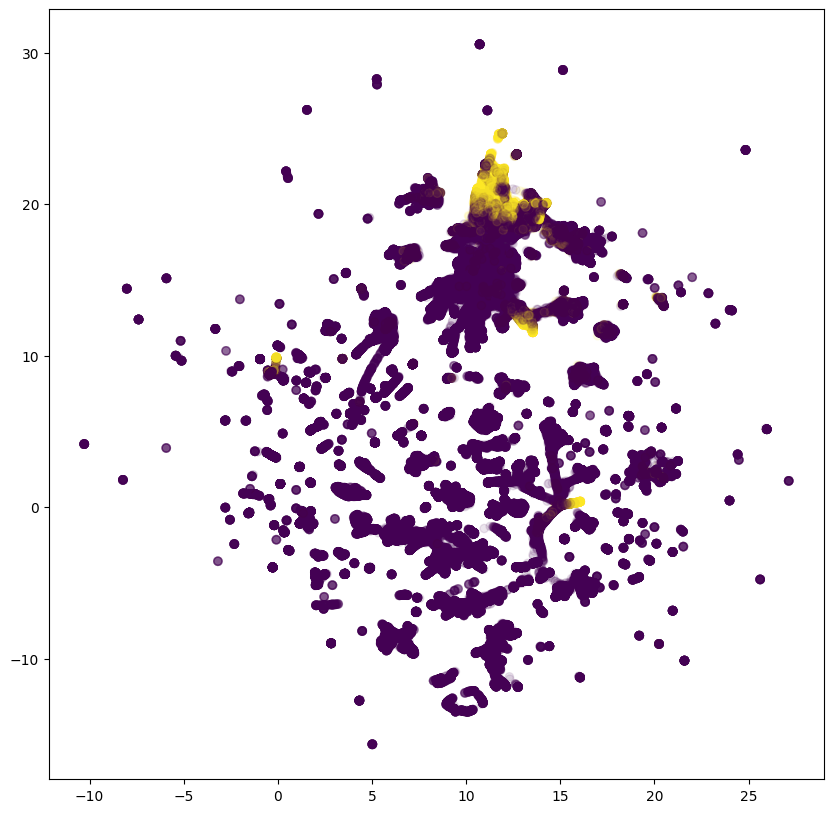

In [57]:
for i in range(1, 5):
    print(i)
    report(df['Class'], df['w_outliers']>=1)    

Нет разницы между 2,3 и 4.
В целом получается довольно не плохой итоговый результат
